In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.svm import SVC

In [3]:
# Scipy for some statistical calculations
from scipy.stats import pearsonr

# Numpy for working with arrays
from numpy import isnan

# Sklearn for imputing missing values and model building
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Matplotlib for plotting 
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The descriptive statistics for the training data show Age, Cabin, and Embarked have some missing values. These will need to be addressed prior to model building. A few possible approaches:

(1) Delete rows with missing values. If there are only a few rows, this is okay. But deleting a large percentage of the rows will reduce the amount of information the data can provide.

(2) Impute missing values. We can fill in missing values with the mean, median, or mode of that variable. Which approach to use depends on the distribution of the data. If the data is heavily skewed, either the median or the mode would be best.

In [5]:
corr, _ = pearsonr(train.Fare, train.Pclass)
print("Pearson correlation between Fare and Pclass: r = {:.3f}".format(corr))

Pearson correlation between Fare and Pclass: r = -0.549


As expected, there is a sizable negative correlation between Fare and Pclass. So, passengers in first class tended to pay larger fares. Thus, I will reduce the dimensionality of the training data later during preprocessing and just drop Fare from the dataset. I am keeping Pclass instead because, having only three possible values, I suspect it will be a more reliable predictor than Fare, which has some unusual values.

In [6]:
# Survived, Pclass, Sex, SibSp, Parch, and Embarked have 
# limited values. Check unique values
print("\nSurvived values are:", train.Survived.unique())
print("\nPclass values are:", train.Pclass.unique())
print("\nSex values are:", train.Sex.unique())
print("\nSibSp values are:", train.SibSp.unique())
print("\nParch values are:", train.Parch.unique())
print("\nEmbarked values are:", train.Embarked.unique())


Survived values are: [0 1]

Pclass values are: [3 1 2]

Sex values are: ['male' 'female']

SibSp values are: [1 0 3 4 2 5 8]

Parch values are: [0 1 2 5 3 4 6]

Embarked values are: ['S' 'C' 'Q' nan]


In [8]:
corr, _ = pearsonr(train.SibSp, train.Parch)
print("Pearson correlation between SibSp and Parch: r = {:.3f}".format(corr))

Pearson correlation between SibSp and Parch: r = 0.415


Since the correlation between SibSp and Parch is 0.415, this may suggest it is redundant to include both covariates in the data. We'll try dropping one of the columns or combining them into a single predictor (feature engineering) and dropping the original two columns. Either way, this will reduce the number of predictors by 1, and thus gives some dimensionality reduction, which can improve predictions.


Pearson correlation between SibSp and Survived: r = -0.035



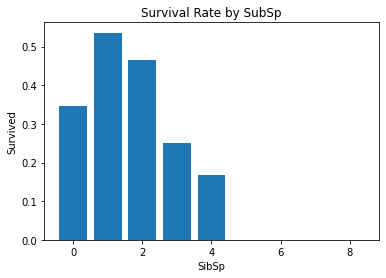


Pearson correlation between Parch and Survived: r = 0.082



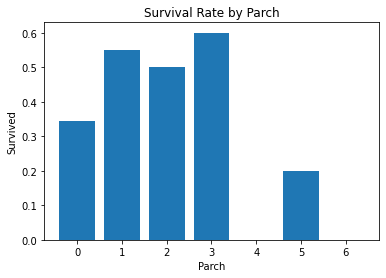

In [9]:
# Calculate correlation between SibSp and Survived, Parch and Survived, and compare which is stronger
corr, _ = pearsonr(train.SibSp, train.Survived)
print("\nPearson correlation between SibSp and Survived: r = {:.3f}\n".format(corr))

# Plotting Survived vs. SibSp or Parch doesn't help, since Survived = (0, 1); plot survival rate for each group instead
# Get a list of the survival rates for each SibSp value; FOR loop that iterates up to the max value (6); add 1 to include 6
SibSp_surv = []
for i in range(train.SibSp.max() + 1):
    surv = train[train.SibSp == i]["Survived"]
    
    # Use IF statement to check that surv has values, otherwise division by zero error will result
    if len(surv) > 0:
        SibSp_surv.append(sum(surv) / len(surv))
    else:
        SibSp_surv.append(0)

plt.bar(range(train.SibSp.max() + 1), SibSp_surv)
plt.xlabel("SibSp")
plt.ylabel("Survived")
plt.title("Survival Rate by SubSp")
plt.show()

corr, _ = pearsonr(train.Parch, train.Survived)
print("\nPearson correlation between Parch and Survived: r = {:.3f}\n".format(corr))

# Get a list of the survival rates for each Parch value; FOR loop that iterates up to the max value (8); add 1 to include 8
Parch_surv = []
for i in range(train.Parch.max() + 1):
    surv = train[train.Parch == i]["Survived"]
    
    # Use IF statement to check that surv has values, otherwise division by zero error will result
    if len(surv) > 0:
        Parch_surv.append(sum(surv) / len(surv))
    else:
        Parch_surv.append(0)

plt.bar(range(train.Parch.max() + 1), Parch_surv)
plt.xlabel("Parch")
plt.ylabel("Survived")
plt.title("Survival Rate by Parch")
plt.show()

Based on the bar graphs of Survival Rates by SibSp and Parch, there is some truth to our previous hunch that passenger with lower values for this variable will have higher survival rates than those with higher values. Further, since the correlations between these predictors and the response, Survived, are both close to zero, I will combine these two predictors into a single predictor and drop SibSp and Parch from the training data set used for model building.

Next, let's take a look at the rate of survival by Pclass, Sex, Embarked, and Age.

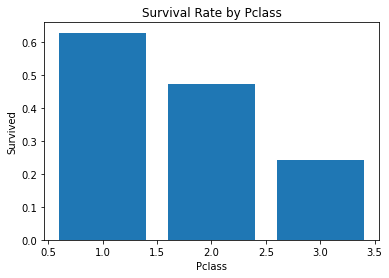

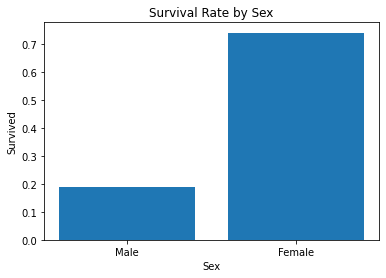

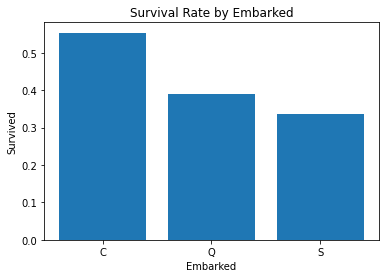

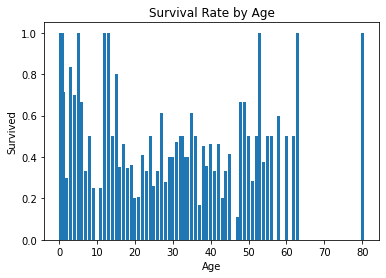

In [10]:
# Get a list of the survival rates for each Pclass value; FOR loop that iterates up to the max value (3)

Pclass_surv = []
for i in range(train.Pclass.max()):
    surv = train[train.Pclass == i + 1]["Survived"]
    
    # Use IF statement to check that surv has values, otherwise division by zero error will result
    if len(surv) > 0:
        Pclass_surv.append(sum(surv) / len(surv))
    else:
        Pclass_surv.append(0)

plt.bar([1, 2, 3], Pclass_surv)
plt.xlabel("Pclass")
plt.ylabel("Survived")
plt.title("Survival Rate by Pclass")
plt.show()

# Get a list of the survival rates for each Sex

men_surv = train[train.Sex == "male"]["Survived"]
men_surv_rate = sum(men_surv) / len(men_surv)
women_surv = train[train.Sex == "female"]["Survived"]
women_surv_rate = sum(women_surv) / len(women_surv)

plt.bar(['Male', 'Female'], [men_surv_rate, women_surv_rate])
plt.xlabel("Sex")
plt.ylabel("Survived")
plt.title("Survival Rate by Sex")
plt.show()

# Get a list of the survival rates for each Embarked value

C_surv = train[train.Embarked == "C"]["Survived"]
C_surv_rate = sum(C_surv) / len(C_surv)
Q_surv = train[train.Embarked == "Q"]["Survived"]
Q_surv_rate = sum(Q_surv) / len(Q_surv)
S_surv = train[train.Embarked == "S"]["Survived"]
S_surv_rate = sum(S_surv) / len(S_surv)


plt.bar(['C', 'Q', 'S'], [C_surv_rate, Q_surv_rate, S_surv_rate])
plt.xlabel("Embarked")
plt.ylabel("Survived")
plt.title("Survival Rate by Embarked")
plt.show()

# Get a list of the survival rates for each Age; use a FOR loop to iterate over elements of the list of unique Ages
age_unique = train.Age.unique()
age_unique = age_unique[~isnan(age_unique)]
age_unique.sort()

age_surv_rate = []
for age in age_unique:
    age_surv = train[train.Age == age]["Survived"]
    
    # Use IF statement to check that age_surv has values, otherwise division by zero error will result
    if len(age_surv) > 0:
        age_surv_rate.append(sum(age_surv) / len(age_surv))
    else:
        age_surv_rate.append(0)
        
plt.bar(age_unique, age_surv_rate)
plt.xlabel("Age")
plt.ylabel("Survived")
plt.title("Survival Rate by Age")
plt.show()

The barplots above show clearly that there are differences in survival rates based on class, sex, and embarking point. Thus, these predictors are useful to add in the model.

For age, however, the trend is not so clear. There is evidence that people under 20 years old overall had a higher survival rate. However, this is seen somewhat for those over 20 as well. Some ages have 100% survival, which is likely due to just one person in that age group, and they made it out. This would be expected with very young and very old passengers.

Based on the above analysis, the predictors I will use to build a model are the following:

Pclass
Sex
Age
A featured based on SibSp and Parch
Embarked
I turn now to preprocessing the data to prepare it for building a model.

The number of missing values for each column is shown below:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


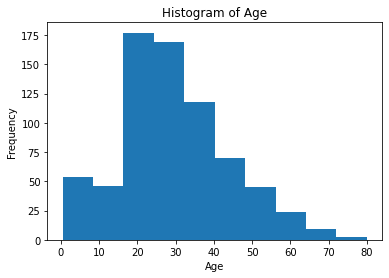


The number of missing values for each column after imputation is shown below:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [11]:
# Check again for missing values
print("The number of missing values for each column is shown below:\n")
print(train.isnull().sum())

# Plot a histogram of Age, to see how to impute its missing values
plt.hist(train.Age)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age")
plt.show()

# Distribution of ages is skewed to the right. Impute with mode (most_frequent) 
from sklearn.impute import SimpleImputer
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputer on Age and Embarked columns
impute_columns = ['Age', 'Embarked']
train[impute_columns] = mode_imputer.fit_transform(train[impute_columns])

# Check for missing values after imputation
print("\nThe number of missing values for each column after imputation is shown below:\n")
print(train.isnull().sum())

# Create a copy of train data
X = train.copy()

# Create Relatives predictor by adding SibSp and Parch; insert into X
X.insert(0, "Relatives", train.SibSp + train.Parch, True)

# Select features Relatives, Pclass, and Age; create new dataframe, X, that will be used in model building
features = ['Relatives', 'Pclass', 'Age']
X = X[features]

# Apply Label Encoder to Sex to transform it into 0s and 1s; insert back into X dataset
Sex_encoded = LabelEncoder().fit_transform(train.Sex)
X.insert(0, "Sex_encoded", Sex_encoded, True)

# Apply One-Hot encoding to Embarked; add back into X dataset
Embarked = pd.get_dummies(train.Embarked)
X = X.join(Embarked)

# Isolate Survived from train data
y = train["Survived"]

In [12]:
display(X.head())

,Sex_encoded,Relatives,Pclass,Age,C,Q,S
0,1,1,3,22.0,0,0,1
1,0,1,1,38.0,1,0,0
2,0,0,3,26.0,0,0,1
3,0,1,1,35.0,0,0,1
4,1,0,3,35.0,0,0,1


In [13]:
# Check for missing values
print("The number of missing values for each column is shown below:\n")
print(test.isnull().sum())

# Distribution of ages is skewed to the right. Impute with mode (most_frequent) 
from sklearn.impute import SimpleImputer
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputer on Age column
test['Age'] = mode_imputer.fit_transform(test['Age'].values.reshape(-1, 1))

# Check for missing values after imputation
print("\nThe number of missing values for each column after imputation is shown below:\n")
print(test.isnull().sum())

# Create a copy of train data
X_test = test.copy()

# Create Relatives predictor by adding SibSp and Parch; insert into X_test
X_test.insert(0, "Relatives", test.SibSp + test.Parch, True)

# Select features Relatives, Pclass, and Age; create new dataframe, X_test, that will be used in model building
features = ['Relatives', 'Pclass', 'Age']
X_test = X_test[features]

# Apply Label Encoder to Sex to transform it into 0s and 1s; insert back into X_test dataset
Sex_encoded = LabelEncoder().fit_transform(test.Sex)
X_test.insert(0, "Sex_encoded", Sex_encoded, True)

# Apply One-Hot encoding to Embarked; add into X_test dataset
Embarked = pd.get_dummies(test.Embarked)
X_test = X_test.join(Embarked)

The number of missing values for each column is shown below:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The number of missing values for each column after imputation is shown below:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [14]:
display(X_test.head())

,Sex_encoded,Relatives,Pclass,Age,C,Q,S
0,1,0,3,34.5,0,1,0
1,0,1,3,47.0,0,0,1
2,1,0,2,62.0,0,1,0
3,1,0,3,27.0,0,0,1
4,0,2,3,22.0,0,0,1


In [15]:
model = SVC(kernel = 'poly', degree = 2)
model.fit(X,y)

SVC(degree=2, kernel='poly')

In [16]:
# Get predictions on test data
preds = model.predict(X_test)

# Save to CSV file
output = pd.DataFrame({'PassengerId': test.PassengerId,
                      'Survived': preds})
output.to_csv('submission.csv', index=False)